Loading data...
Successfully loaded geophone_walking_20250924_112851.csv
Successfully loaded geophone_running_20250924_113158.csv
Successfully loaded geophone_digging_20250924_113535.csv
Engineering new 'pattern' features...
Calculating rolling features for window size 25...
Original rows: 5120, Cleaned rows (after dropna): 5048

Training model using these 5 selected features:
- velocity_mms_roll_std
- velocity_mms_roll_mean
- velocity_mms_roll_max
- velocity_mms_roll_min
- velocity_mms_roll_median

Splitting data into train/test sets...
Training samples: 3533, Testing samples: 1515
Training Random Forest model...
Model training complete.

--- MODEL EVALUATION ON TEST DATA ---
Overall Accuracy: 95.71%

--- Classification Report ---
              precision    recall  f1-score   support

     digging       0.95      0.94      0.95       500
     running       0.97      0.96      0.96       512
     walking       0.95      0.97      0.96       503

    accuracy                           0

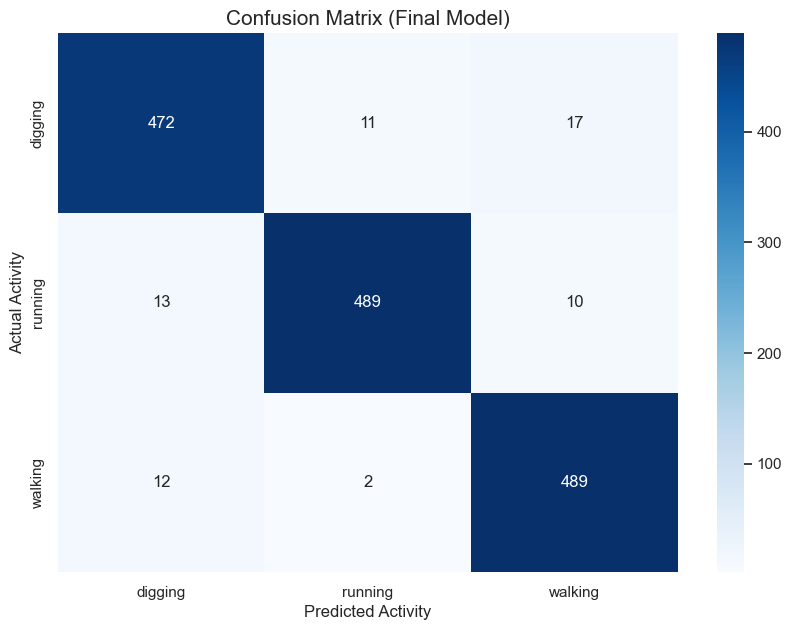

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Step 1: Load and Label Each Dataset ---
print("Loading data...")
files = {
    'walking': 'geophone_walking_20250924_112851.csv',
    'running': 'geophone_running_20250924_113158.csv',
    'digging': 'geophone_digging_20250924_113535.csv'
}

data_frames = []
for activity, file_name in files.items():
    try:
        df = pd.read_csv(file_name)
        df['activity'] = activity
        data_frames.append(df)
        print(f"Successfully loaded {file_name}")
    except FileNotFoundError:
        print(f"Error: Could not find file {file_name}. Make sure it's in the same folder.")
        exit()

if not data_frames:
    print("No data was loaded. Exiting.")
    exit()

# --- Step 2: Combine and Engineer Features ---
print("Engineering new 'pattern' features...")
full_data = pd.concat(data_frames, ignore_index=True)
full_data['timestamp'] = pd.to_datetime(full_data['timestamp'])
full_data = full_data.sort_values(by='timestamp').reset_index(drop=True)

window_size = 25
source_col = 'velocity_mms' # The sensor signal we'll analyze

# Create a dictionary to hold our new features
rolling_features = {}
# Group by activity *once* to prevent data from one activity leaking into another
grouped_data = full_data.groupby('activity')[source_col]

print(f"Calculating rolling features for window size {window_size}...")
# Create a set of features that describe the signal's pattern
rolling_features[f'{source_col}_roll_std'] = grouped_data.rolling(window=window_size).std()
rolling_features[f'{source_col}_roll_mean'] = grouped_data.rolling(window=window_size).mean()
rolling_features[f'{source_col}_roll_max'] = grouped_data.rolling(window=window_size).max()
rolling_features[f'{source_col}_roll_min'] = grouped_data.rolling(window=window_size).min()
rolling_features[f'{source_col}_roll_median'] = grouped_data.rolling(window=window_size).median()

# Add the new features back to the main DataFrame
for name, feature_series in rolling_features.items():
    # We must reset the index from the groupby to align with full_data
    full_data[name] = feature_series.reset_index(level=0, drop=True)

# CRITICAL: Drop all rows with NaN values (from the start of the rolling windows)
full_data_clean = full_data.dropna()
print(f"Original rows: {len(full_data)}, Cleaned rows (after dropna): {len(full_data_clean)}")

# --- Step 3: Define Features (X) and Target (y) ---

# 'y' is the 'activity' column we want to predict.
y = full_data_clean['activity']

# 'X' will *ONLY* use our new engineered features
# This is the most important change to fix the low accuracy.
features_to_use = list(rolling_features.keys())
X = full_data_clean[features_to_use]

print(f"\nTraining model using these {len(features_to_use)} selected features:")
for f in features_to_use:
    print(f"- {f}")

class_labels = sorted(y.unique())

# --- Step 4: Split Data into Training and Testing Sets ---
print("\nSplitting data into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y # 'stratify=y' is crucial for imbalanced datasets
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# --- Step 5: Train the Random Forest Model ---
print("Training Random Forest model...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("Model training complete.")

# --- Step 6: Test the Model and Evaluate Accuracy ---
print("\n--- MODEL EVALUATION ON TEST DATA ---")
y_pred = model.predict(X_test)

# 1. Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# 2. Classification Report
print("\n--- Classification Report ---")
# [Image of a classification report]
print(classification_report(y_test, y_pred, target_names=class_labels))

# 3. Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Save a heatmap of the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Activity', fontsize=12)
plt.ylabel('Actual Activity', fontsize=12)
plt.title('Confusion Matrix (Final Model)', fontsize=15)
plt.savefig('confusion_matrix_final.png')
print("\nSaved confusion matrix plot as 'confusion_matrix_final.png'")

# --- Step 7: Show Feature Importance ---
print("\n--- Feature Importance ---")
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features_to_use,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)
print("\n--- Script Finished ---")